Repo card metadata block was not found. Setting CardData to empty.


X shape: torch.Size([8, 3, 128, 128])
Noisy X shape torch.Size([8, 3, 128, 128])
Epoch:5, loss: 0.11039786599576473
Epoch:10, loss: 0.1005650982260704
Epoch:15, loss: 0.1051863394677639
Epoch:20, loss: 0.1030555497854948


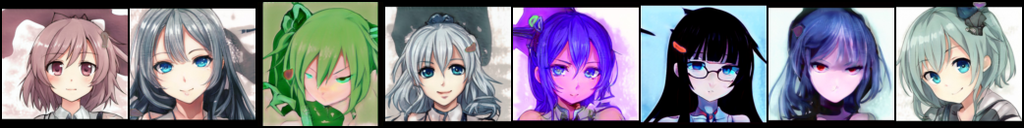

In [5]:

import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
  """给定一批图像，创建一个网格并将其转换为PIL"""
  x = x * 0.5 + 0.5  # 将（-1，1）区间映射回（0，1）区间
  grid = torchvision.utils.make_grid(x)
  grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
  return grid_im

def make_grid(images, size=64):
  """给定一个PIL图像列表，将它们叠加成一行以便查看"""
  output_im = Image.new("RGB", (size * len(images), size))
  for i, im in enumerate(images):
      output_im.paste(im.resize((size, size)), (i * size, 0))
  return output_im

# 对于Mac，可能需要设置成device = 'mps'(未经测试)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision
from datasets import load_dataset
from torchvision import transforms

#dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
#dataset = load_dataset("huggan/ae_photos", split="train")
#dataset = load_dataset("huggan/metfaces", split="train")
#dataset = load_dataset("huggan/few-shot-dog", split="train")
#dataset = load_dataset("huggan/pokemon", split="train")
# dataset = load_dataset("huggan/few-shot-panda", split="train")
#dataset = load_dataset("huggan/few-shot-skulls", split="train")
#dataset = load_dataset("huggan/few-shot-universe", split="train")
#dataset = load_dataset("huggan/few-shot-cat", split="train")
dataset = load_dataset("huggan/few-shot-anime-face", split="train")
#few-shot-anime-face
#few-shot-universe

#few-shot-obama
#anime-faces
#few-shot-skulls

# 也可以从本地文件夹中加载图像
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# 我们将在32×32像素的正方形图像上进行训练，但你也可以尝试更大尺寸的图像
#image_size = 32
image_size = 128  

# 如果GPU内存不足，你可以减小batch_size
batch_size = 16 # 64

# 定义数据增强过程
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # 调整大小
        transforms.RandomHorizontalFlip(),            # 随机翻转
        transforms.ToTensor(),              # 将张量映射到(0,1)区间
        transforms.Normalize([0.5], [0.5]), # 映射到(-1, 1)区间
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in
       examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# 创建一个数据加载器，用于批量提供经过变换的图像
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

# 仅添加了少量噪声
# 方法一：
from diffusers import DDIMScheduler, DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# 'cosine'调度方式，这种方式可能更适合尺寸较小的图像

# 方法二：
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

from diffusers import UNet2DModel

# 创建模型
model = UNet2DModel(
    sample_size=image_size,   # 目标图像分辨率
    in_channels=3,            # 输入通道数，对于RGB图像来说，通道数为3
    out_channels=3,           # 输出通道数
    layers_per_block=2,       # 每个UNet块使用的ResNet层数
    #block_out_channels=(64, 128, 128, 256),  更多的通道→更多的参数
    block_out_channels=(128, 256, 256, 512),  # 提升各层的通道数，增强模型的容量

    down_block_types=(
        "DownBlock2D",        # 一个常规的ResNet下采样模块
        "DownBlock2D",
        "AttnDownBlock2D",    # 一个带有空间自注意力的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # 一个带有空间自注意力的ResNet上采样模块
        "UpBlock2D",
        "UpBlock2D",          # 一个常规的ResNet上采样模块
    ),
)
model.to(device)

# 设定噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(20):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # 为图片添加采样噪声
        noise = torch.randn(clean_images.shape).to(clean_images.
           device)
        bs = clean_images.shape[0]

        # 为每张图片随机采样一个时间步
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,),
            device=clean_images.device
        ).long()

        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(clean_images,
           noise, timesteps)

        # 获得模型的预测结果
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # 迭代模型参数
        optimizer.step()
        optimizer.zero_grad()
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


# 随机初始化（8张随机图片）
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # 获得模型的预测结果
    with torch.no_grad():
        residual = model(sample, t).sample

    # 根据预测结果更新图像
    sample = noise_scheduler.step(residual, t, sample).prev_sample

#show_images(sample)
show_images(xb).resize((8 * image_size, image_size), resample=Image.LANCZOS)

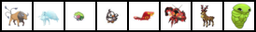

In [4]:
show_images(xb).resize((8 * image_size, image_size), resample=Image.LANCZOS)


In [4]:
sample = torch.randn(8, 3, 16, 16).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # 获得模型的预测结果
    with torch.no_grad():
        residual = model(sample, t).sample

    # 根据预测结果更新图像
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [37]:
from datasets import list_datasets

# 列出所有可用的数据集
all_datasets = list_datasets()

# 筛选出包含 'huggan' 的数据集
huggan_datasets = [d for d in all_datasets if 'huggan' in d]

print("Available datasets from 'huggan':", huggan_datasets)


C:\Users\weina\AppData\Local\Temp\ipykernel_42864\3082486327.py:4: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


Available datasets from 'huggan': ['huggan/anime-faces', 'huggan/edges2shoes', 'huggan/facades', 'huggan/night2day', 'huggan/maps', 'huggan/cityscapes', 'huggan/ae_photos', 'huggan/CelebA-HQ', 'huggan/cartoon-faces', 'huggan/cats', 'huggan/AFHQ', 'huggan/AFHQv2', 'huggan/metfaces', 'huggan/horse2zebra', 'huggan/monet2photo', 'huggan/cezanne2photo', 'huggan/ukiyoe2photo', 'huggan/vangogh2photo', 'huggan/apple2orange', 'huggan/iphone2dslr_flower', 'huggan/summer2winter_yosemite', 'huggan/grumpifycat', 'huggan/CelebA-faces-with-attributes', 'huggan/few-shot-obama', 'huggan/few-shot-grumpy-cat', 'huggan/few-shot-panda', 'huggan/few-shot-cat', 'huggan/few-shot-dog', 'huggan/few-shot-anime-face', 'huggan/pokemon', 'huggan/few-shot-art-painting', 'huggan/few-shot-fauvism-still-life', 'huggan/few-shot-flat-colored-patterns', 'huggan/few-shot-moongate', 'huggan/few-shot-pokemon', 'huggan/few-shot-shells', 'huggan/few-shot-skulls', 'huggan/inat_butterflies', 'huggan/inat_butterflies_top10k', 'hu